# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [15]:
# Define transforms
## YOUR CODE HERE ##
batch_size = 64

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.ColorJitter(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10('data/train', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10('data/test', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [8]:
def show5(img_loader):
    batch = next(iter(img_loader))
    labels = batch[1][0:5]
    images = batch[0][0:5]
    fig = plt.figure(figsize=(10,4))
    
    for i in range(5):
        ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
        image = images[i].numpy()
        image = image / 2 + 0.5 # unnormalize the images

        plt.imshow(np.rot90(image.T, k=3))
        ax.set_title(classes[labels[i]]) # set img label as plot title

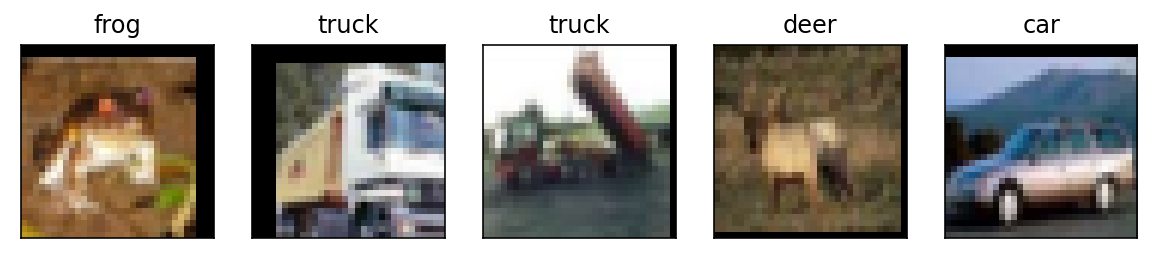

In [9]:
# Explore data
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show5(trainloader)

In [10]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [11]:
# transfer other net
#model = torchvision.models.densenet121(pretrained=True)
#model


In [12]:
#for param in model.parameters():
#    param.requires_grad = True

In [51]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional layer (added one sublayer)
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=6, out_channels=24, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=6, out_channels=24, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected layer (added one sublayer)
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=32, out_features=10)
        )
            
    def forward(self, x):
        # Convolutional layer
        x1 = torch.split(x, 2)[0]
        x2 = torch.split(x, 2)[1]
        x1 = self.conv_layer_1(x1)
        x2 = self.conv_layer_2(x2)
        
        x = torch.add(x1, x2)
        x = x.view(x.size(0), -1)

        # Fully Connected layer
        x = self.fc_layer(x)
        
        return x

model = Net()

if train_on_gpu:
    model.cuda()

model

Net(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(6, 24, kernel_size=(5, 5), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(24, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): R

In [49]:
x = torch.arange(24).reshape(4, 6)
x1 = torch.split(x, 2)[0]
x2 = torch.split(x, 2)[1]
print(x1)
print(x2)
x = torch.add(x1, x2)
print(x)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])
tensor([[12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23]])
tensor([[12, 14, 16, 18, 20, 22],
        [24, 26, 28, 30, 32, 34]])


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [45]:
## YOUR CODE HERE ##
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss(reduction='sum')

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
#optimizer = optim.Adadelta(model.parameters(), lr=0.01)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)

from torchsummary import summary
summary(model, input_size=(batch_size, 3, 32, 32))

model.to(device);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       456
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       3,624
|    └─MaxPool2d: 2-4                    --
|    └─Conv2d: 2-5                       19,232
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-7                       456
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       3,624
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      19,232
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-3                        --
|    └─Linear: 2-13                      131,328
|    └─ReLU: 2-14                        --
|    └─Linear: 2-15                      16,448
|    └─ReLU: 2-16                        --
|    └─Linear: 2-17                      2,080
|    └─ReLU: 2-18                        --

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [52]:
## YOUR CODE HERE ##
epochs = 100
running_loss = 0
print_every = 50
train_losses, valid_losses, valid_accuracy = [], [], []
best = 0
for epoch in range(epochs):
    for inputs, labels in trainloader:
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
                    
            test_loss += batch_loss.item()
                    
            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
        train_losses.append(running_loss / len(trainloader))
        valid_losses.append(test_loss / len(testloader))
        valid_accuracy.append(accuracy / len(testloader))
        if(accuracy/len(testloader) > best):
            best = accuracy/len(testloader)
                    
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainloader):.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {100*accuracy/len(testloader):.2f}%")
        running_loss = 0
        model.train()
print(f"Best accuracy: {100*best:.2f}%")

ValueError: Expected input batch_size (2) to match target batch_size (64).

Plot the training loss (and validation loss/accuracy, if recorded).

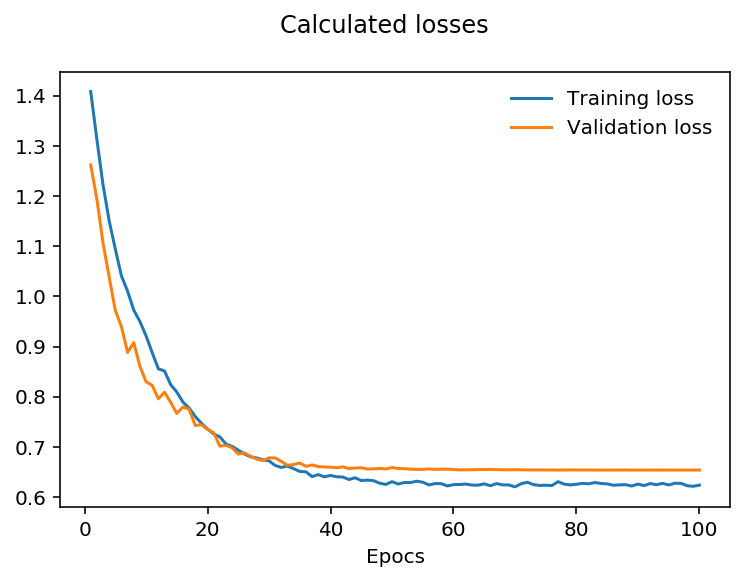

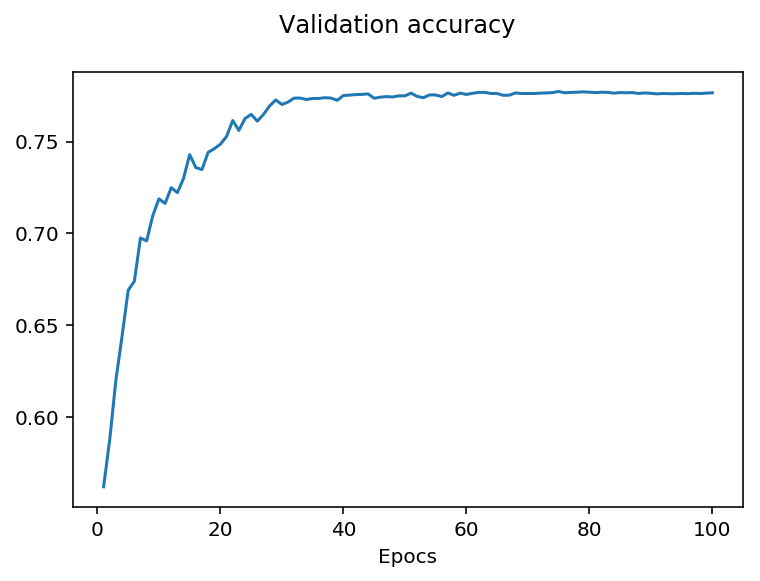

In [13]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.suptitle('Calculated losses')
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation loss')
plt.xlabel('Epocs')
plt.legend(frameon=False)
plt.show()

plt.suptitle('Validation accuracy')
plt.plot(range(1,len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('Epocs')
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [14]:
## YOUR CODE HERE ##
# Original source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0

input_count = 0
with torch.no_grad(): # no gradient calculation since not training
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # Transfer images and labels to default device
        # Calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        input_count += labels.size(0)
        
print("Accuracy of the network on the {:,} test images: {:.2f}%".format(input_count, (100 * correct / total)))

Accuracy of the network on the 10,000 test images: 77.61%


In [15]:
# Original source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad(): # no gradient calculation since not training
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # Transfer images and labels to default device
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
print("Accuracy for each class:")
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("- Class {:5s} {:.2f}%".format(classname, accuracy))

Accuracy for each class:
- Class plane 81.30%
- Class car   88.00%
- Class bird  68.60%
- Class cat   55.10%
- Class deer  77.30%
- Class dog   67.40%
- Class frog  86.40%
- Class horse 82.20%
- Class ship  85.40%
- Class truck 84.40%


## Saving your model
Using `torch.save`, save your model for future loading.

In [16]:
## YOUR CODE HERE ##
# Updated for full checkpoint (including optimizer and scheduler) based on feedback

full_checkpoint = {'state_dict':model.state_dict(),
                   'optim_dict':optimizer.state_dict(),
                   'scheduler': scheduler,
                   'epoch':epoch}

torch.save(full_checkpoint, 'full_checkpoint.pt')

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



**Double click this cell to modify it**

I have built an image classifier using a neural network model in PyTorch. I trained the model using the CIFAR-10 dataset, and in testing the model achieved a 77.61% accuracy rate. The result is 7.61% better than Detectocorp's algorithm which has a 70% accuracy rate for the same dataset. And the model has still much room for improvement. Thus, I would recommend building an in-house solution.



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).